# Paper histograms

In [1]:
from coffea import util
from coffea import hist
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
p_types = ['eplus','piplus']
rbm_paths= ['/home/blazerjia/Publication/Saved_samples/RBM/eplus/wandb/run-20230526_005306-36kf9r7d',
           "/home/blazerjia/Publication/Saved_samples/RBM/piplus/wandb/run-20230526_000511-li89mnsl"]
p_paths = ['/home/blazerjia/Publication/Saved_samples/DWAVE/eplus/wandb/run-20230526_003448-zonp856v',
           "/home/blazerjia/Publication/Saved_samples/DWAVE/piplus/wandb/run-20230526_001933-j9xaqijz"]

In [3]:
_COLOR_DICT = {"eplus":"c", "piplus":"y"}

In [4]:
_HISTOGRAMS = ["totalEnergyHist", "layer_0_EnergyHist", "layer_1_EnergyHist", "layer_2_EnergyHist",
               "layer_0_sparsityHist", "layer_1_sparsityHist", "layer_2_sparsityHist",
               "layer_0_fracEnergyHist", "layer_1_fracEnergyHist", "layer_2_fracEnergyHist",
               "showerDepthHist", "sampleEnergyHist", "dwTotalEnergyHist"]

_SCALES = ["linear"]

In [5]:
def plot_single_hist(c_hist, xscale, ax, p_type, layerhist=False, layernum=-1, synthetic=True):
#         ax.set_xlim(0.2, 1)
        """
        Args:
            c_hist - coffea hist object
            xscale - xscale of the histogram (log, linear, ...)
            ax - Axes object to plot on
        Returns:
            image - PIL image object
        """
        assert len(c_hist.axes()) == 2, "Histogram should only have two axes - Dataset type and Bins"
        ax_0, ax_1 = c_hist.axes()[0], c_hist.axes()[1]
        
        if isinstance(ax_0, hist.Cat) and isinstance(ax_1, hist.Bin):
            cat_ax = ax_0
            bin_ax = ax_1
        elif isinstance(ax_0, hist.Bin) and isinstance(ax_0, hist.Cat):
            bin_ax = ax_0
            cat_ax = ax_1
        else:
            raise ValueError("Expected categorical and bin axis")
        
        cat_names = [identifier.name for identifier in cat_ax.identifiers()]
        bins = [ax_bin.hi for ax_bin in bin_ax.identifiers()]
        
        value_dict = {cat_name:c_hist.values(overflow='all')[(cat_name,)] for cat_name in cat_names}
      
        if True:
            hi_bins = [ax_bin.hi for ax_bin in bin_ax.identifiers()]
            lo_bins = [ax_bin.lo for ax_bin in bin_ax.identifiers()]
            diff_bins = [hi_bin - lo_bin for hi_bin, lo_bin in zip(hi_bins, lo_bins)][0]

        bins = [bins[0]] + bins

        for cat_name in cat_names:
            if cat_name == "input" or cat_name == "samples" or cat_name == "true":
                value_dict[cat_name]=value_dict[cat_name][:-1]
                qvae_size=sum(value_dict[cat_name])
                scaled_value_dict = value_dict[cat_name]/(qvae_size*diff_bins)
                scaled_value_dict[0] = 0.
                scaled_value_dict[-1] = 0.
                if p_type == "eplus":
                    p_label = r"""$e^{+}$"""
                elif p_type == "gamma":
                    p_label = r"""$\gamma$  """
                else:
                    p_label = r"""$\pi^{+}$"""   
                if cat_name == "input":
                    if synthetic == True:
                        ax.fill_between(bins, scaled_value_dict, label=p_label + " " + "GEANT", color=_COLOR_DICT[p_type], step="post", alpha=0.5)
                else:
                    if synthetic == True:
                        ax.step(bins, scaled_value_dict, label=p_label + " " + "QVAE", where="post", color=_COLOR_DICT[p_type], linewidth=10.0)
                    else:
                        ax.step(bins, scaled_value_dict, label=p_label + " " + "DVAE", linestyle='dashed', where="post", color=_COLOR_DICT[p_type], linewidth=10.0)
            
        if layerhist:
            xlabel = "Layer " + str(layernum) + " {0}".format(bin_ax.label)
        else:
            xlabel = bin_ax.label
            
        ax.set_xlabel(xlabel, fontsize='120')
        # ax.set_xlim(0,1)
        for spine in ax.spines.values():
            spine.set_color('black') 
            spine.set_linewidth(8)
        
        if xscale == "log":
            ax.set_ylabel(c_hist.label + " / Bin Width", fontsize='120')
        else:
            ax.set_ylabel('Density', fontsize='120')
        
        return

In [6]:
def plot_hist(ax, p_types, p_paths, rbm_paths, h_type, yscale, xscale="linear", legend_loc=None, legend_col=2):
    hist_dict = {}
    for p_type, p_path in zip(p_types, p_paths):
        hist_dict[p_type] = util.load(os.path.join(p_path, "files/{0}_{1}.coffea".format(p_type, h_type)))
    
    for p_type in p_types:
        single_hist = hist_dict[p_type]
        
        if "layer" in h_type:
            layerhist = True
            layer = int(h_type[6:7])
            plot_single_hist(single_hist, xscale, ax, p_type, layerhist=True, layernum=layer, synthetic=True)
        else:
            plot_single_hist(single_hist, xscale, ax, p_type, synthetic=True)
            
    hist_dict = {}
    for p_type, rbm_path in zip(p_types, rbm_paths):
        hist_dict[p_type] = util.load(os.path.join(rbm_path, "files/{0}_{1}.coffea".format(p_type, h_type)))
    
    for p_type in p_types:
        single_hist = hist_dict[p_type]
        
        if "layer" in h_type:
            layerhist = True
            layer = int(h_type[6:7])
            plot_single_hist(single_hist, xscale, ax, p_type, layerhist=True, layernum=layer, synthetic=False)
        else:
            plot_single_hist(single_hist, xscale, ax, p_type, synthetic=False)
            
    handles, labels = ax.get_legend_handles_labels()
    order = [0,1,4,2,3,5]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],prop={'size': 80}, loc=legend_loc, ncol=legend_col, framealpha=0) 
    #ax.legend(prop={'size': 40}, loc=legend_loc, ncol=legend_col, framealpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=120)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

In [7]:
def plot_all_hists_paper(savefig=False, show=True):
#     plt.figure(figsize=(80, 80)) 
    fig, axs = plt.subplots(1, 2, figsize=(90, 40))
    fig.suptitle(' ', fontsize=90)
    # Plot the histograms
    plot_hist(axs[0], p_types, p_paths, rbm_paths, "layer_1_fracEnergyHist", "log", legend_loc=(0.02,0.81))
    plot_hist(axs[1], p_types, p_paths, rbm_paths, "layer_1_sparsityHist", "log", legend_loc=(0.18,0.81))
    if savefig:
        #fig.tight_layout()
        plt.savefig(os.path.join(os.getcwd(), "svg/paper_layer_1_hists.pdf"))
    if show:
        plt.show()
    plt.close()

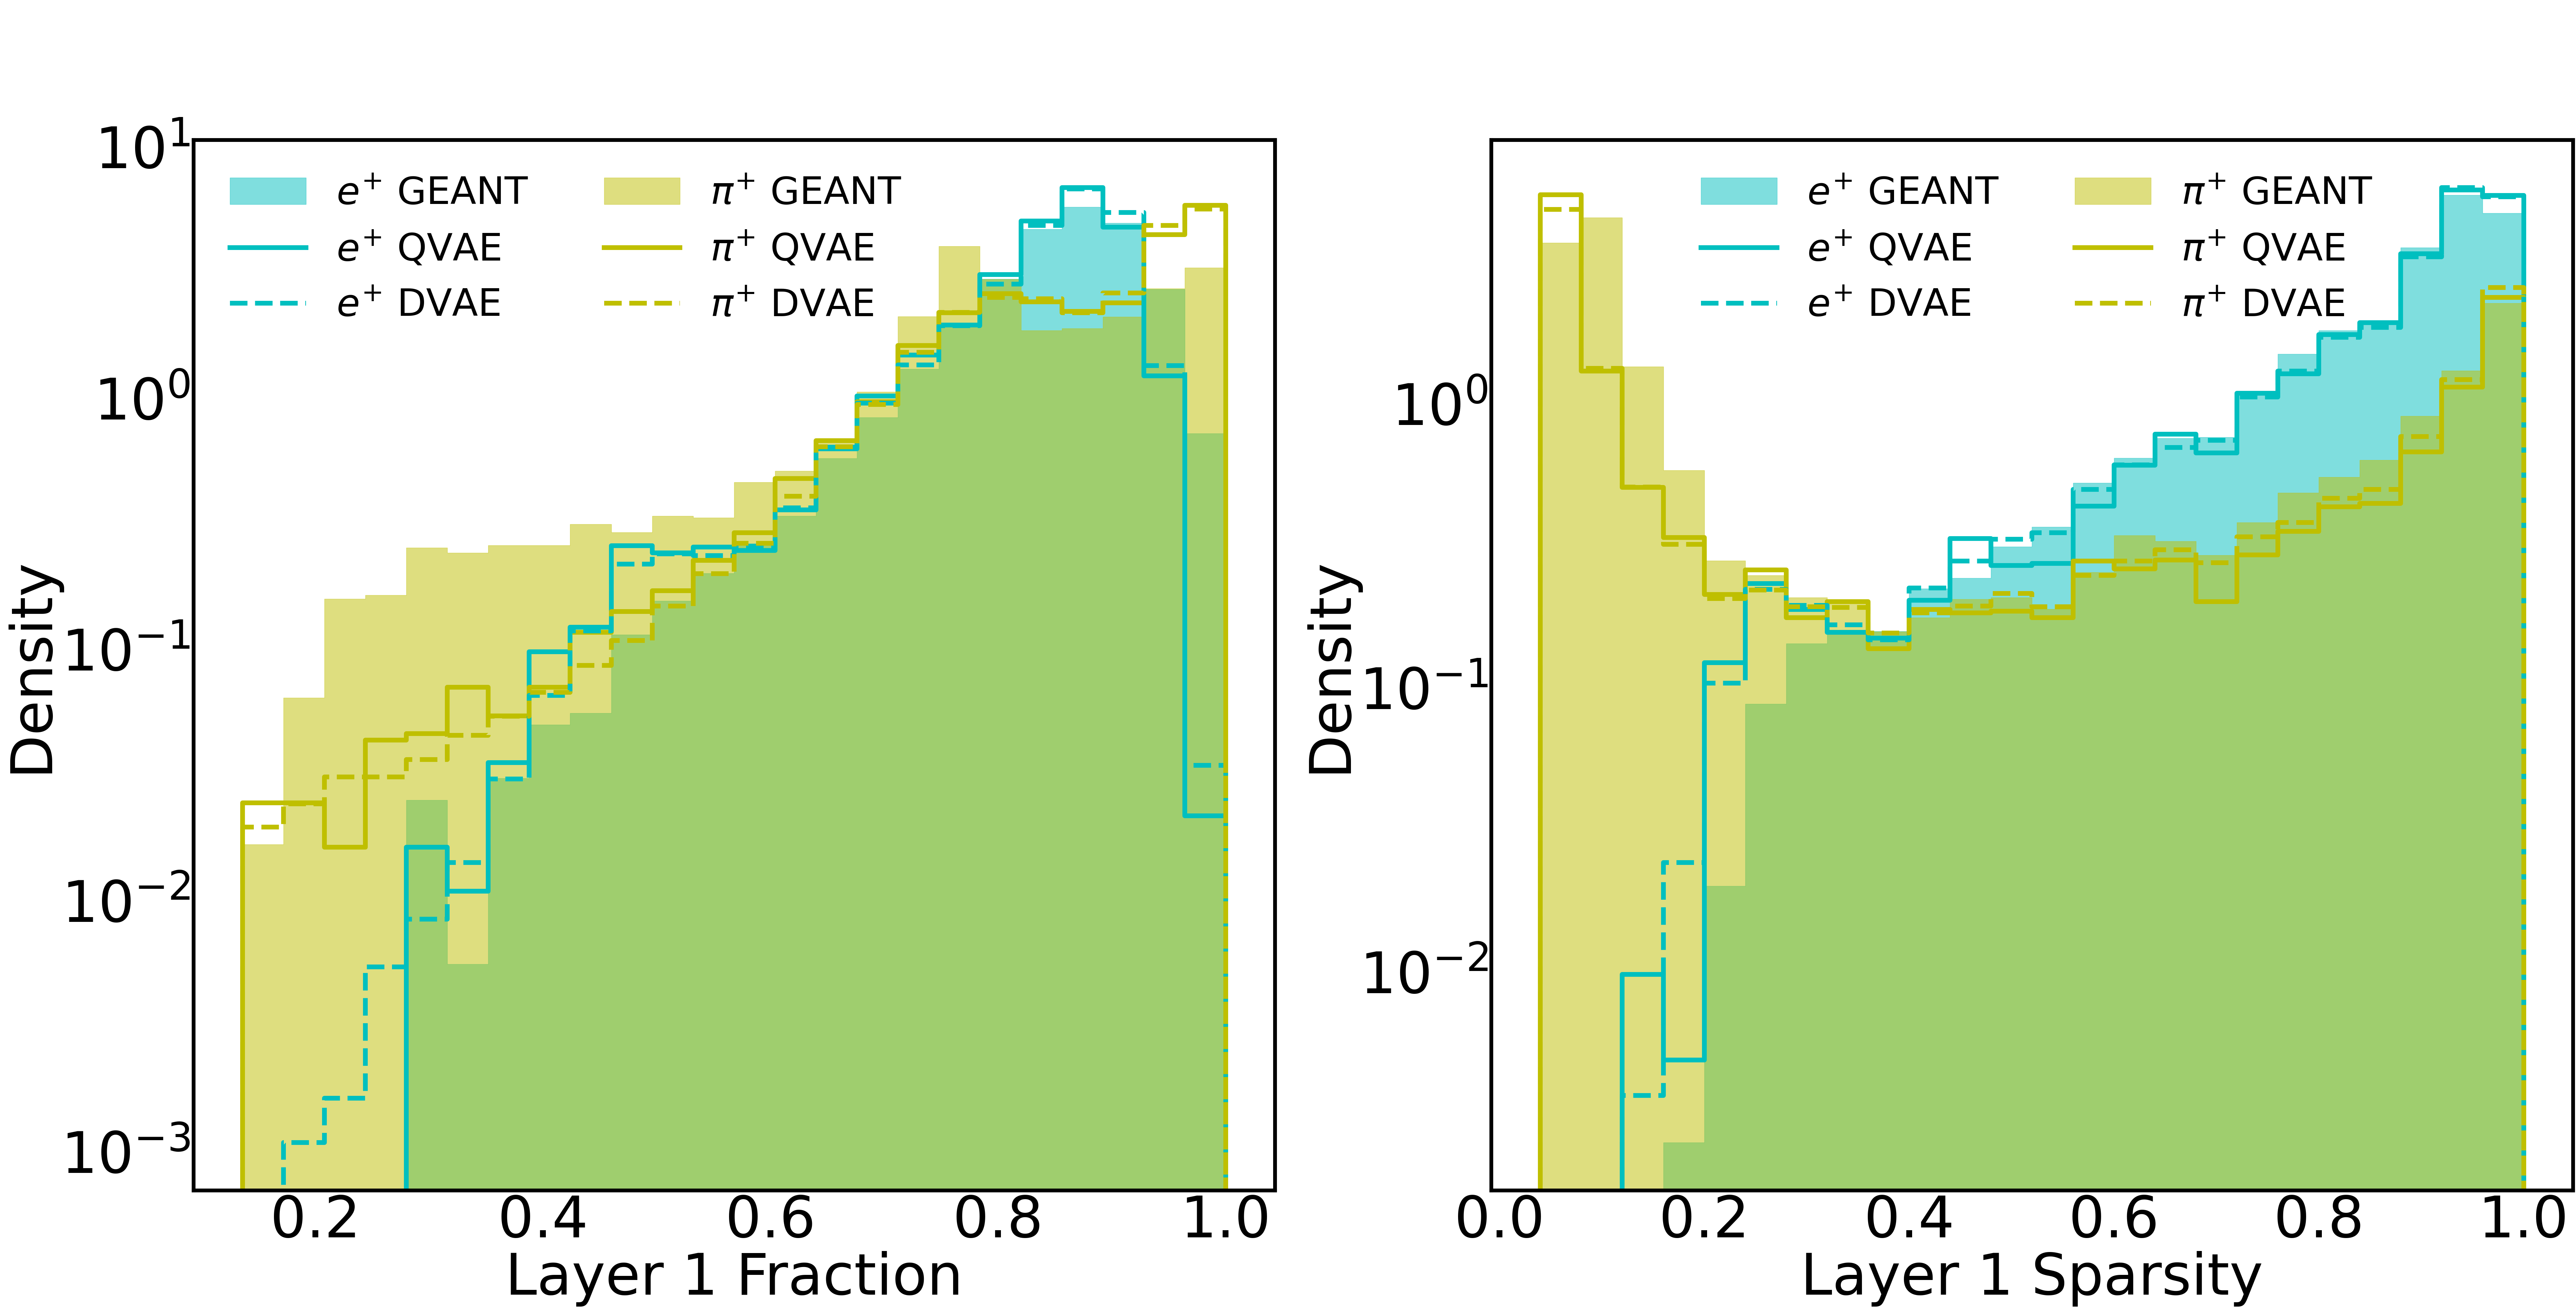

In [8]:
plot_all_hists_paper(savefig=True)